In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data

100% 55.9M/55.9M [00:00<00:00, 78.7MB/s]



In [ ]:
! unzip kepler-labelled-time-series-data

Archive:  kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import ndimage
from sklearn import  metrics
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
%matplotlib inline

In [ ]:
train=pd.read_csv('/content/exoTrain.csv')
test=pd.read_csv('/content/exoTest.csv')

In [ ]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
train.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.00000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,1.410852e+02,1.124563e+02,1.050821e+02,7.720985e+01,60.143330,17.630999,-54.355089,-103.08460,-144.560114,-113.322037,-68.828616,-32.839733,31.196475,88.517940,175.080436,233.700224,281.801687,4.643881e+02,5.347781e+02,5.686202e+02,5.575065e+02,5.667802e+02,5.469081e+02,1.775987e+02,1.977492e+02,2.291148e+02,2.441020e+02,2.501690e+02,2.613476e+02,2.326228e+02,...,8.001983e+02,8.456118e+02,7.564445e+02,116.982994,158.543973,129.188885,5.817181,-97.778421,-84.500629,-2.522744,125.509414,354.448954,6.254212e+02,8.012768e+02,106.772064,80.353945,12.455127,-94.172579,-181.646112,-320.240619,-358.358437,-323.468262,-281.609027,-213.522064,-107.086774,-110.572898,-71.794968,-31.777614,72.747847,126.815573,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,1.942289e+04,1.832810e+04,1.768321e+04,1.731920e+04,16647.817648,16725.088231,17162.322247,17356.98839,16979.436723,16011.508248,15118.835589,14255.363528,14048.475841,14618.614614,15246.020915,16803.416700,17930.530299,2.523553e+04,2.704750e+04,2.964609e+04,3.315534e+04,3.679672e+04,4.144422e+04,2.071160e+04,2.108089e+04,2.144121e+04,2.175216e+04,2.180420e+04,2.164199e+04,2.132321e+04,...,5.116648e+04,5.829319e+04,5.898207e+04,16075.902775,16263.350901,15613.273881,14397.292446,14887.907167,14466.376116,12079.533421,12455.557157,20116.003038,3.307799e+04,4.613980e+04,15648.242604,15514.533197,14142.137616,13113.457203,13161.476260,14165.866392,15083.632082,14587.243316,13548.583112,11544.505620,10369.103689,10653.997273,10238.433598,10849.383610,16548.155180,20119.224581,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,-2.223300e+05,-2.279016e+05,-2.996757e+05,-4.453612e+05,-557042.690000,-695994.840000,-815633.560000,-880865.85000,-892477.410000,-85

In [ ]:
train.LABEL.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [ ]:
train.LABEL = [1 if each == 2 else 0 for each in train.LABEL]
test.LABEL = [1 if each == 2 else 0 for each in test.LABEL]

In [ ]:
train.LABEL.value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

# preprocessing

In [ ]:
train_X = train.drop('LABEL', axis=1)
train_y = train['LABEL'].values
test_X = test.drop('LABEL', axis=1)
test_y = test['LABEL'].values

In [ ]:
train_X = np.abs(np.fft.fft(train_X))
test_X = np.abs(np.fft.fft(test_X))

train_X = normalized = normalize(train_X)
test_X = normalize(test_X)

# train_X = filtered = ndimage.filters.gaussian_filter(train_X, sigma=10)
# test_X = ndimage.filters.gaussian_filter(test_X, sigma=10)

train_X  = savgol_filter(train_X ,21,1,deriv=0)
test_X = savgol_filter(test_X,21,1,deriv=0)

# scaler = RobustScaler()
# train_X = scaler.fit_transform(train_X)
# test_X = scaler.transform(test_X)

std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
test_X = std_scaler.fit_transform(test_X)

# now for SMOTE
sm = SMOTE(random_state=0)
train_X,train_y = sm.fit_resample(train_X,train_y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
dt=tree.DecisionTreeClassifier()

In [ ]:
algo_list = []
algo_list.append(('K Nearest Neighbour', KNeighborsClassifier(21)))
algo_list.append(('Logistic Regression', LogisticRegression(solver='liblinear')))
algo_list.append(('Support Vector Machine', SVC()))
algo_list.append(('Decision Tree', tree.DecisionTreeClassifier())) 
algo_list.append(('Random Forest', RandomForestClassifier()))
algo_list.append(('XGBoost',XGBClassifier()))

In [ ]:
#finding accuracy
num_folds = 10
results = []
names = []

for name, model in algo_list:
    kfold = KFold(n_splits=num_folds, random_state=21,shuffle=True)
    start = time.time()
    cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

K Nearest Neighbour: 0.999703 (0.000634) (run time: 21.443594)
Logistic Regression: 0.999703 (0.000634) (run time: 144.582884)
Support Vector Machine: 0.999703 (0.000634) (run time: 20.352690)
Decision Tree: 1.000000 (0.000000) (run time: 47.241123)
Random Forest: 1.000000 (0.000000) (run time: 62.501415)


In [ ]:
#finding f1
num_folds = 10
results = []
names = []

for name, model in algo_list:
    kfold = KFold(n_splits=num_folds, random_state=21,shuffle=True)
    start = time.time()
    cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring='f1')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

K Nearest Neighbour: 0.999708 (0.000624) (run time: 21.694792)
Logistic Regression: 0.999708 (0.000624) (run time: 142.052075)
Support Vector Machine: 0.999708 (0.000624) (run time: 18.869177)
Decision Tree: 1.000000 (0.000000) (run time: 51.146886)
Random Forest: 1.000000 (0.000000) (run time: 66.280999)


In [ ]:
# finding precision
num_folds = 10
results = []
names = []

for name, model in algo_list:
    kfold = KFold(n_splits=num_folds, random_state=21,shuffle=True)
    start = time.time()
    cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring='precision')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

K Nearest Neighbour: 0.999417 (0.001246) (run time: 21.508292)
Logistic Regression: 0.999417 (0.001246) (run time: 141.856961)
Support Vector Machine: 0.999417 (0.001246) (run time: 19.039577)
Decision Tree: 1.000000 (0.000000) (run time: 50.176016)
Random Forest: 1.000000 (0.000000) (run time: 60.972116)


In [ ]:
#finding recall
num_folds = 10
results = []
names = []

for name, model in algo_list:
    kfold = KFold(n_splits=num_folds, random_state=21,shuffle=True)
    start = time.time()
    cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring='recall')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

K Nearest Neighbour: 1.000000 (0.000000) (run time: 21.285329)
Logistic Regression: 1.000000 (0.000000) (run time: 140.862002)
Support Vector Machine: 1.000000 (0.000000) (run time: 19.257791)
Decision Tree: 1.000000 (0.000000) (run time: 45.568408)
Random Forest: 1.000000 (0.000000) (run time: 60.380729)


# KNN

Accuracy on Training set:0.99901
Accuracy on Test set:0.70175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


F1 score of minority class:0.05556
precision score of minority class:0.02857
recall score of minority class:1.00000


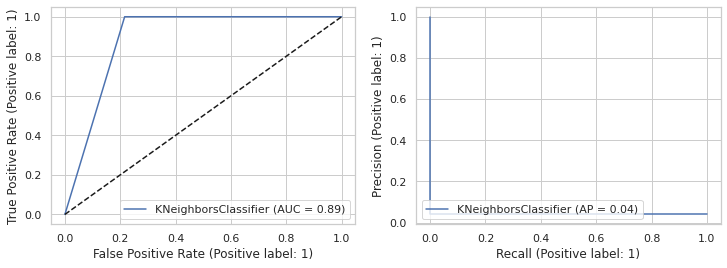

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       565
           1       0.03      1.00      0.06         5

    accuracy                           0.70       570
   macro avg       0.51      0.85      0.44       570
weighted avg       0.99      0.70      0.82       570

[[395 170]
 [  0   5]]


In [ ]:
knn=KNeighborsClassifier(21)
knn.fit(train_X,train_y)
y_pred_knn=knn.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(knn.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(knn.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(knn,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(knn, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_knn,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_knn,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_knn,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_knn))
print(confusion_matrix(test_y, y_pred_knn))

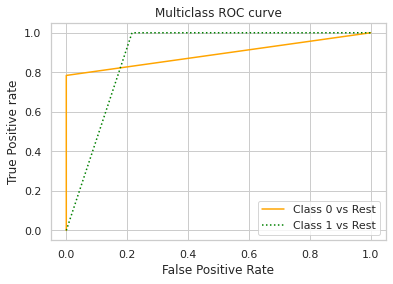

In [ ]:
pred_prob = knn.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# LOG REG

Accuracy on Training set:1.00000
Accuracy on Test set:0.56491
F1 score of minority class:0.03876
precision score of minority class:0.01976
recall score of minority class:1.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


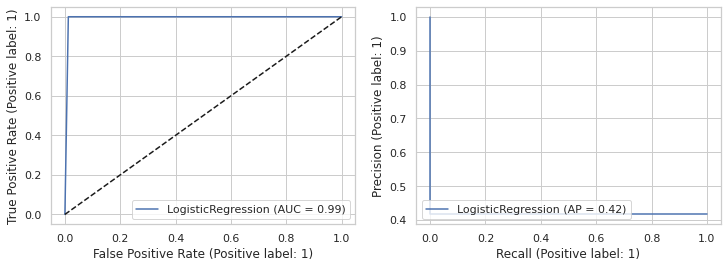

              precision    recall  f1-score   support

           0       1.00      0.56      0.72       565
           1       0.02      1.00      0.04         5

    accuracy                           0.56       570
   macro avg       0.51      0.78      0.38       570
weighted avg       0.99      0.56      0.71       570

[[317 248]
 [  0   5]]


In [ ]:
lgc=LogisticRegression(solver='liblinear')
lgc.fit(train_X,train_y)
y_pred_lgc=lgc.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(lgc.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(lgc.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(lgc,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(lgc, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_lgc,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_lgc,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_lgc,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_lgc))
print(confusion_matrix(test_y, y_pred_lgc))

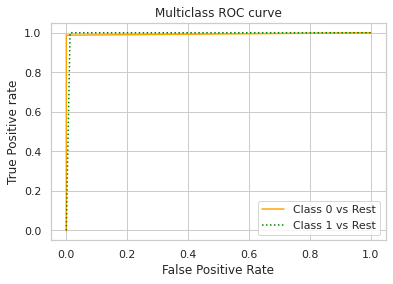

In [ ]:
pred_prob = lgc.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# SVC

Accuracy on Training set:0.99931
Accuracy on Test set:0.67018


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


F1 score of minority class:0.05051
precision score of minority class:0.02591
recall score of minority class:1.00000


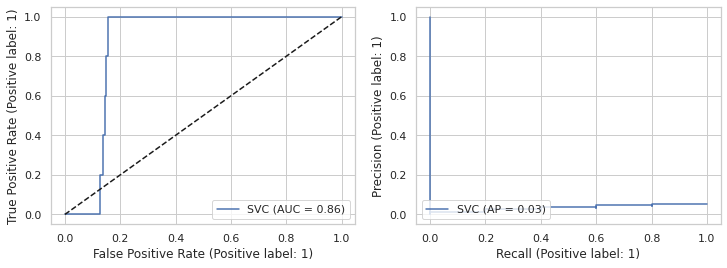

              precision    recall  f1-score   support

           0       1.00      0.67      0.80       565
           1       0.03      1.00      0.05         5

    accuracy                           0.67       570
   macro avg       0.51      0.83      0.43       570
weighted avg       0.99      0.67      0.79       570

[[377 188]
 [  0   5]]


In [ ]:
svc=SVC(probability=True)
svc.fit(train_X,train_y)
y_pred_svc=svc.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(svc.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(svc.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(svc,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(svc, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_svc,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_svc,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_svc,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_svc))
print(confusion_matrix(test_y, y_pred_svc))

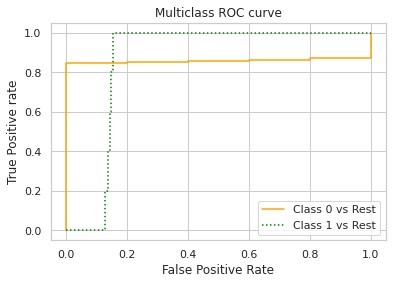

In [ ]:
pred_prob = svc.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# DECISION TREE

Accuracy on Training set:1.00000
Accuracy on Test set:0.46667
F1 score of minority class:0.03185
precision score of minority class:0.01618
recall score of minority class:1.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


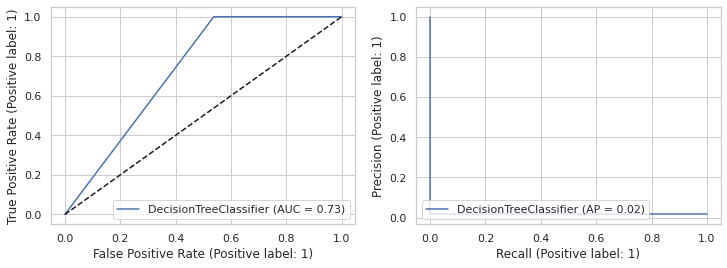

              precision    recall  f1-score   support

           0       1.00      0.46      0.63       565
           1       0.02      1.00      0.03         5

    accuracy                           0.47       570
   macro avg       0.51      0.73      0.33       570
weighted avg       0.99      0.47      0.63       570

[[261 304]
 [  0   5]]


In [ ]:
dtc=tree.DecisionTreeClassifier(max_depth=5, random_state=13)
dtc.fit(train_X,train_y)
y_pred_dtc=dtc.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(dtc.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(dtc.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(dtc,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(dtc, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_dtc,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_dtc,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_dtc,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_dtc))
print(confusion_matrix(test_y, y_pred_dtc))

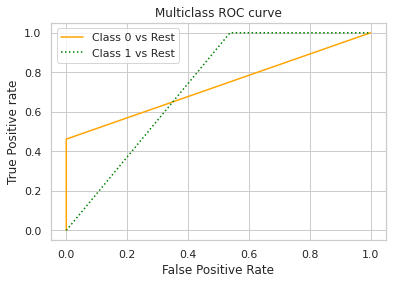

In [ ]:
pred_prob = dtc.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# RANDOM FOREST

Accuracy on Training set:1.00000
Accuracy on Test set:0.46491
F1 score of minority class:0.03175
precision score of minority class:0.01613
recall score of minority class:1.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


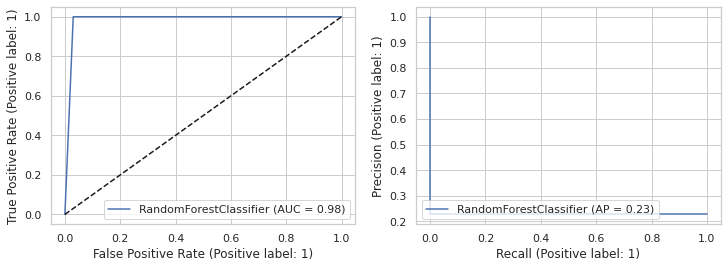

              precision    recall  f1-score   support

           0       1.00      0.46      0.63       565
           1       0.02      1.00      0.03         5

    accuracy                           0.46       570
   macro avg       0.51      0.73      0.33       570
weighted avg       0.99      0.46      0.63       570

[[260 305]
 [  0   5]]


In [ ]:
rfc=RandomForestClassifier()
rfc.fit(train_X,train_y)
y_pred_rfc=rfc.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(rfc.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(rfc.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(rfc,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(rfc, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_rfc,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_rfc,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_rfc,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_rfc))
print(confusion_matrix(test_y, y_pred_rfc))

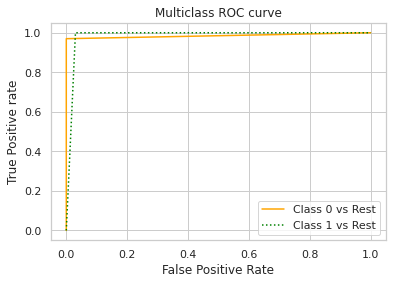

In [ ]:
pred_prob = rfc.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# XGBOOSTING

Accuracy on Training set:1.00000
Accuracy on Test set:0.50526
F1 score of minority class:0.03175
precision score of minority class:0.01613
recall score of minority class:1.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


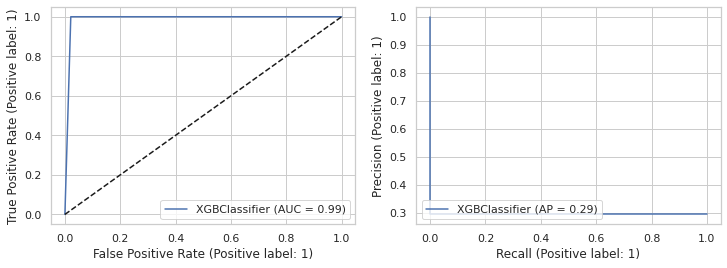

              precision    recall  f1-score   support

           0       1.00      0.46      0.63       565
           1       0.02      1.00      0.03         5

    accuracy                           0.46       570
   macro avg       0.51      0.73      0.33       570
weighted avg       0.99      0.46      0.63       570

[[260 305]
 [  0   5]]


In [ ]:
xgbc=XGBClassifier()
xgbc.fit(train_X,train_y)
y_pred_xgbc=rfc.predict(test_X)

print("Accuracy on Training set:{:.5f}".format(xgbc.score(train_X,train_y)))
print("Accuracy on Test set:{:.5f}".format(xgbc.score(test_X,test_y)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
metrics.plot_roc_curve(xgbc,test_X, test_y,ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
ax = fig.add_subplot(1,2,2)
metrics.plot_precision_recall_curve(xgbc, test_X, test_y,ax=ax)

f1 = metrics.f1_score(test_y, y_pred_xgbc,pos_label=1)
prec=metrics.precision_score(test_y, y_pred_xgbc,pos_label=1)
rec=metrics.recall_score(test_y, y_pred_xgbc,pos_label=1)
print("F1 score of minority class:{:.5f}".format(f1))
print("precision score of minority class:{:.5f}".format(prec))
print("recall score of minority class:{:.5f}".format(rec))
plt.show()

print(classification_report(test_y, y_pred_xgbc))
print(confusion_matrix(test_y, y_pred_xgbc))

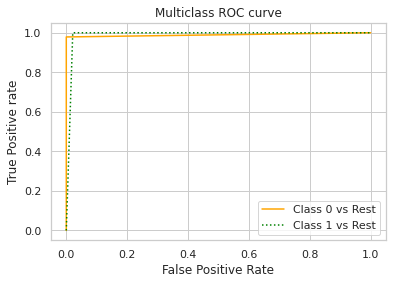

In [ ]:
pred_prob = xgbc.predict_proba(test_X)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='green', label='Class 1 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

# ANN

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout,Reshape,Flatten,MaxPool1D, BatchNormalization
from sklearn.utils import shuffle

In [ ]:
train_X.shape

(10100, 3197)

In [ ]:
train_X,train_y = shuffle(train_X,train_y)

In [ ]:
import tensorflow as tf
from keras import backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
modelann = Sequential([
    keras.layers.Dense(16,input_dim=3197,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    Dropout(0.25), 
    keras.layers.Dense(32,activation='relu'),
    # Dropout(0.25),
    keras.layers.Dense(16,activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(8,activation='relu'), 
    # Dropout(0.25),
    keras.layers.Dense(1,activation='sigmoid')
])

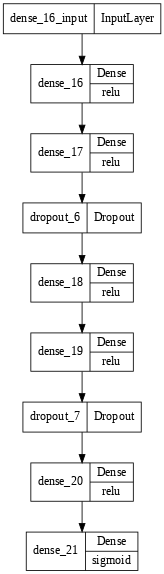

In [ ]:
tf.keras.utils.plot_model(
    modelann,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    # expand_nested=False,
    dpi=60,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
modelann.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                51168     
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                544       
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                

In [ ]:
modelann.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [ ]:
historyann=modelann.fit(train_X,train_y,epochs=20,batch_size=32,validation_split=0.3,shuffle=True)

Epoch 1/20
221/221 [==============================] - 4s 6ms/step - loss: 0.3439 - accuracy: 0.8416 - precision: 0.8040 - recall: 0.9062 - auc: 0.9258 - f1_score: 0.8495 - val_loss: 0.1339 - val_accuracy: 0.9545 - val_precision: 0.9153 - val_recall: 1.0000 - val_auc: 0.9924 - val_f1_score: 0.9551
Epoch 2/20
221/221 [==============================] - 1s 4ms/step - loss: 0.1559 - accuracy: 0.9569 - precision: 0.9385 - recall: 0.9784 - auc: 0.9834 - f1_score: 0.9568 - val_loss: 0.0945 - val_accuracy: 0.9663 - val_precision: 0.9360 - val_recall: 1.0000 - val_auc: 0.9949 - val_f1_score: 0.9666
Epoch 3/20
221/221 [==============================] - 1s 4ms/step - loss: 0.1042 - accuracy: 0.9672 - precision: 0.9492 - recall: 0.9876 - auc: 0.9916 - f1_score: 0.9668 - val_loss: 0.0880 - val_accuracy: 0.9677 - val_precision: 0.9383 - val_recall: 1.0000 - val_auc: 0.9961 - val_f1_score: 0.9675
Epoch 4/20
221/221 [==============================] - 1s 4ms/step - loss: 0.0869 - accuracy: 0.9731 - prec

In [ ]:
y_pred_ann=modelann.predict(test_X)

In [ ]:
modelann.evaluate(test_X)

18/18 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - f1_score: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

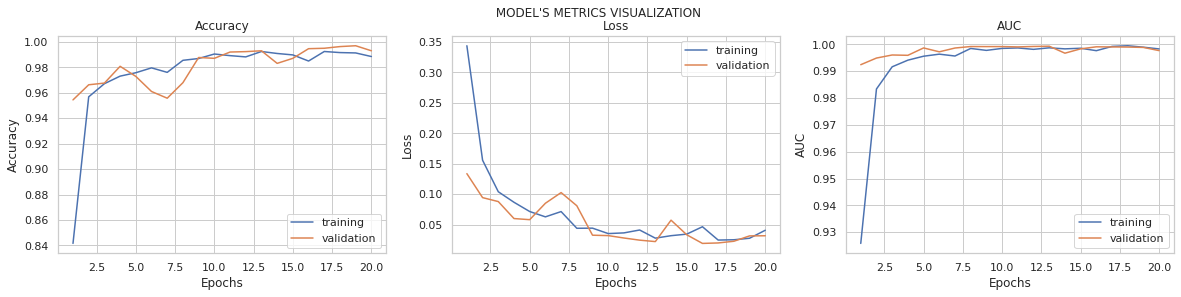

In [ ]:
def Train_Val_Plot1(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot1(historyann.history['accuracy'],historyann.history['val_accuracy'],
               historyann.history['loss'],historyann.history['val_loss'],
               historyann.history['auc'],historyann.history['val_auc']
              )

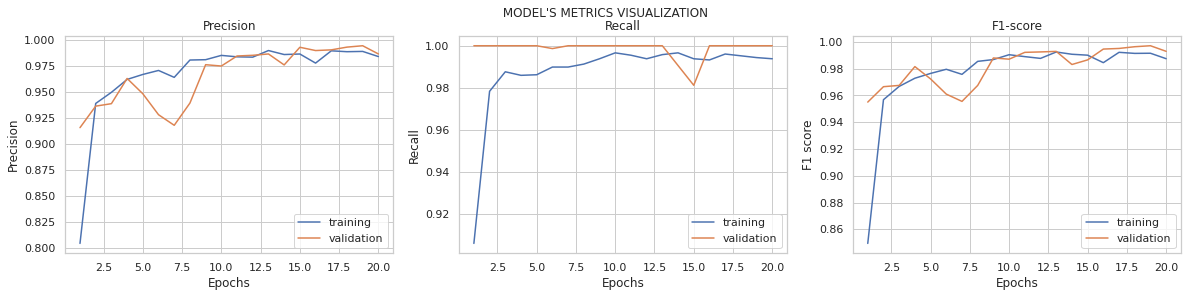

In [ ]:
def Train_Val_Plot2(precision,val_precision,recall,val_recall,f1,val_f1):
    
    fig, (ax4,ax5,ax6) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

   
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), recall)
    ax5.plot(range(1, len(val_f1) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(f1) + 1), f1)
    ax6.plot(range(1, len(val_f1) + 1), val_f1)
    ax6.set_title('F1-score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('F1 score')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot2(historyann.history['precision'],historyann.history['val_precision'],
               historyann.history['recall'],historyann.history['val_recall'],
               historyann.history['f1_score'],historyann.history['val_f1_score']
              )

In [ ]:
# fig = plt.figure(figsize=(12,4))
# ax = fig.add_subplot(1,2,1)
# metrics.plot_roc_curve(model,test_X, test_y,ax=ax)
# plt.plot([0, 1], [0, 1], 'k--')
# ax = fig.add_subplot(1,2,2)
# metrics.plot_precision_recall_curve(model, test_X, test_y,ax=ax)

# f1 = metrics.f1_score(test_y, y_pred_ann,pos_label=2)
# print("F1 score of minority class:",f1)
# plt.show()
y_class_pred = (modelann.predict(test_X) > 0.5).astype("int32")
y_pred_ann = modelann.predict(test_X)
    
print(classification_report(test_y,y_class_pred))
print(confusion_matrix(test_y,y_class_pred))

y_class_pred = (modelann.predict(train_X) > 0.5).astype("int32")
y_pred_ann = modelann.predict(train_X)
    
print(classification_report(train_y,y_class_pred))
print(confusion_matrix(train_y,y_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       565
           1       0.33      1.00      0.50         5

    accuracy                           0.98       570
   macro avg       0.67      0.99      0.75       570
weighted avg       0.99      0.98      0.99       570

[[555  10]
 [  0   5]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5050
           1       0.99      1.00      1.00      5050

    accuracy                           1.00     10100
   macro avg       1.00      1.00      1.00     10100
weighted avg       1.00      1.00      1.00     10100

[[5000   50]
 [   0 5050]]


In [ ]:
from sklearn.metrics import roc_curve
y_pred_ann= modelann.predict(test_X).ravel()
fpr_ann, tpr_ann, thresholds_ann = roc_curve(test_y, y_pred_ann)

from sklearn.metrics import auc
auc_ann = auc(fpr_ann, tpr_ann)
print(auc_ann)

0.9982300884955753


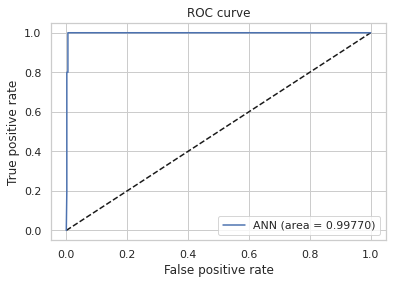

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='ANN (area = {:.5f})'.format(auc_ann))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.5)
# plt.ylim(0, 5)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

# CNN

In [ ]:
modelcnn = Sequential()
modelcnn.add(Reshape((3197, 1), input_shape=(3197,)))
modelcnn.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(train_X.shape[1], 1)))
modelcnn.add(Dropout(0.2))
modelcnn.add(Flatten())
modelcnn.add(Dense(16, activation="relu"))
modelcnn.add(Dense(1, activation="sigmoid"))

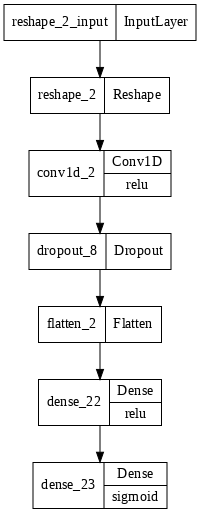

In [ ]:
tf.keras.utils.plot_model(
    modelcnn,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
modelcnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 3197, 1)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3195, 8)           32        
                                                                 
 dropout_8 (Dropout)         (None, 3195, 8)           0         
                                                                 
 flatten_2 (Flatten)         (None, 25560)             0         
                                                                 
 dense_22 (Dense)            (None, 16)                408976    
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 409,025
Trainable params: 409,025
Non-tr

In [ ]:
modelcnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [ ]:
historycnn=modelcnn.fit(train_X,train_y,epochs=20,batch_size=32,validation_split=0.3,shuffle=True)

Epoch 1/20
221/221 [==============================] - 10s 39ms/step - loss: 0.1928 - accuracy: 0.9255 - precision: 0.8934 - recall: 0.9674 - auc: 0.9810 - f1_score: 0.9309 - val_loss: 0.0974 - val_accuracy: 0.9640 - val_precision: 0.9452 - val_recall: 0.9839 - val_auc: 0.9957 - val_f1_score: 0.9630
Epoch 2/20
221/221 [==============================] - 8s 34ms/step - loss: 0.0573 - accuracy: 0.9812 - precision: 0.9761 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9806 - val_loss: 0.0221 - val_accuracy: 0.9947 - val_precision: 0.9894 - val_recall: 1.0000 - val_auc: 0.9993 - val_f1_score: 0.9949
Epoch 3/20
221/221 [==============================] - 8s 34ms/step - loss: 0.0376 - accuracy: 0.9884 - precision: 0.9847 - recall: 0.9924 - auc: 0.9983 - f1_score: 0.9876 - val_loss: 0.0237 - val_accuracy: 0.9970 - val_precision: 0.9940 - val_recall: 1.0000 - val_auc: 0.9999 - val_f1_score: 0.9971
Epoch 4/20
221/221 [==============================] - 8s 34ms/step - loss: 0.0213 - accuracy: 0.9941 -

In [ ]:
modelcnn.evaluate(test_X)

18/18 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - f1_score: 0.0000e+00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

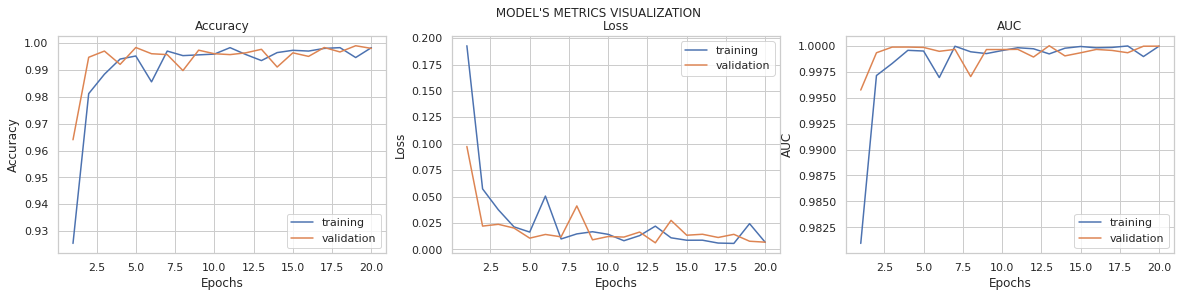

In [ ]:
def Train_Val_Plot1(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot1(historycnn.history['accuracy'],historycnn.history['val_accuracy'],
               historycnn.history['loss'],historycnn.history['val_loss'],
               historycnn.history['auc'],historycnn.history['val_auc']
              )

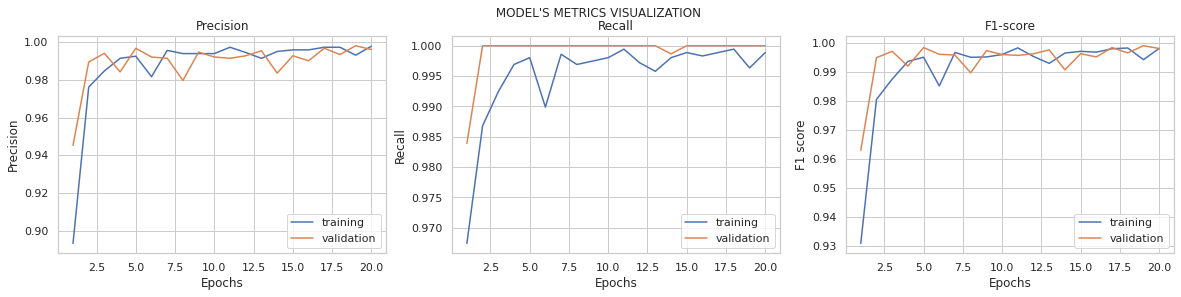

In [ ]:
def Train_Val_Plot2(precision,val_precision,recall,val_recall,f1,val_f1):
    
    fig, (ax4,ax5,ax6) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

   
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), recall)
    ax5.plot(range(1, len(val_f1) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(f1) + 1), f1)
    ax6.plot(range(1, len(val_f1) + 1), val_f1)
    ax6.set_title('F1-score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('F1 score')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot2(historycnn.history['precision'],historycnn.history['val_precision'],
               historycnn.history['recall'],historycnn.history['val_recall'],
               historycnn.history['f1_score'],historycnn.history['val_f1_score']
              )

In [ ]:
y_class_pred = (modelcnn.predict(test_X) > 0.5).astype("int32")
y_pred_cnn = modelcnn.predict(test_X)
    
print(classification_report(test_y,y_class_pred))
print(confusion_matrix(test_y,y_class_pred))

y_class_pred = (modelcnn.predict(train_X) > 0.5).astype("int32")
y_pred_cnn = modelcnn.predict(train_X)
    
print(classification_report(train_y,y_class_pred))
print(confusion_matrix(train_y,y_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.50      1.00      0.67         5

    accuracy                           0.99       570
   macro avg       0.75      1.00      0.83       570
weighted avg       1.00      0.99      0.99       570

[[560   5]
 [  0   5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00      5050

    accuracy                           1.00     10100
   macro avg       1.00      1.00      1.00     10100
weighted avg       1.00      1.00      1.00     10100

[[5040   10]
 [   0 5050]]


In [ ]:
from sklearn.metrics import roc_curve
y_pred_cnn= modelcnn.predict(test_X).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(test_y, y_pred_cnn)

from sklearn.metrics import auc
auc_cnn = auc(fpr_cnn, tpr_cnn)
print(auc_cnn)

0.9984070796460177


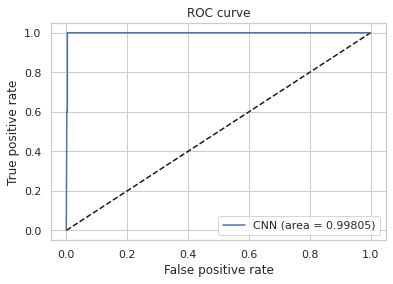

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.5f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.5)
# plt.ylim(0, 5)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

# RNN

In [ ]:
raw_data = np.loadtxt('/content/exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt('/content/exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

In [ ]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train,
                                                  test_size=0.3, random_state=123)

In [ ]:
np.set_printoptions(threshold=np.inf)
X_train_r = np.expand_dims(X_train, axis=2)
X_val_r = np.expand_dims(X_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [ ]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [ ]:
train_X.shape

(10100, 3197)

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10100, 1, 3197) (10100,) (570, 1, 3197) (570,)


In [ ]:
train_X.shape

(10100, 1, 3197)

In [ ]:
from keras.layers import Input,Permute,LSTM, concatenate,SimpleRNN
from keras.models import Model
modellstm=Sequential()
# model.add(SimpleRNN(256, input_shape=(train_X.shape[1], train_X.shape[2])))
modellstm.add(LSTM(8,input_shape=(train_X.shape[1], 1)))
modellstm.add(Dense(16,activation='relu'))
modellstm.add(Dropout(0.25))
modellstm.add(Dense(32, activation='relu'))
modellstm.add(Dense(32, activation='relu'))
modellstm.add(Dropout(0.25))
modellstm.add(Dense(16, activation='relu'))
modellstm.add(Dense(1, activation='sigmoid'))

In [ ]:
# from keras.layers import Input,Permute,LSTM, concatenate,SimpleRNN
# from keras.models import Model
# modellstm=Sequential()
# # model.add(SimpleRNN(256, input_shape=(train_X.shape[1], train_X.shape[2])))
# modellstm.add(LSTM(20,input_shape=(train_X.shape[1], 1)))
# modellstm.add(Dense(20,activation='relu'))
# modellstm.add(Dropout(0.25))
# modellstm.add(Dense(40, activation='relu'))
# modellstm.add(Dense(50, activation='relu'))
# modellstm.add(Dropout(0.25))
# modellstm.add(Dense(16, activation='relu'))
# modellstm.add(Dense(1, activation='sigmoid'))

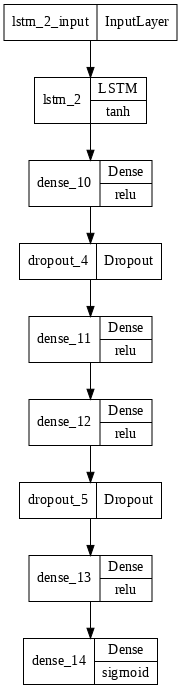

In [ ]:
tf.keras.utils.plot_model(
    modellstm,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
modellstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_10 (Dense)            (None, 16)                144       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

In [ ]:
modellstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [ ]:
y_class_pred = (modellstm.predict(test_X) > 0.5).astype("int32")
y_pred_lstm = modellstm.predict(test_X)
    
print(classification_report(test_y,y_class_pred))
print(confusion_matrix(test_y,y_class_pred))

# y_class_pred = (modellstm.predict(train_X) > 0.5).astype("int32")
# y_pred_lstm = modellstm.predict(train_X)
    
# print(classification_report(train_y,y_class_pred))
# print(confusion_matrix(train_y,y_class_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       565
           1       0.03      0.40      0.05         5

    accuracy                           0.87       570
   macro avg       0.51      0.64      0.49       570
weighted avg       0.99      0.87      0.92       570

[[494  71]
 [  3   2]]


In [ ]:
from sklearn.metrics import roc_curve
y_pred_lstm= modellstm.predict(test_X).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(test_y, y_pred_lstm)

from sklearn.metrics import auc
auc_lstm = auc(fpr_lstm, tpr_lstm)
print(auc_lstm)

1.0


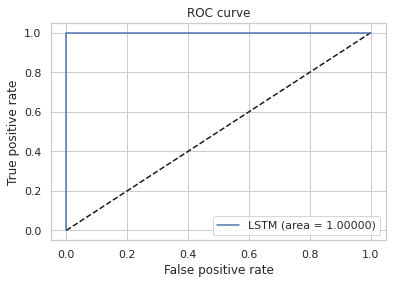

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.5f})'.format(auc_lstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [ ]:
y_class_pred = (modellstm.predict(test_X) > 0.5).astype("int32")
y_pred_lstm = modellstm.predict(test_X)
    
print(classification_report(test_y,y_class_pred))
print(confusion_matrix(test_y,y_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       565
           1       0.15      1.00      0.26         5

    accuracy                           0.95       570
   macro avg       0.58      0.98      0.62       570
weighted avg       0.99      0.95      0.97       570

[[537  28]
 [  0   5]]


In [ ]:
historylstm=modellstm.fit(train_X,train_y,epochs=20,batch_size=32,validation_split=0.3)

Epoch 1/20
221/221 [==============================] - 228s 1s/step - loss: 0.3282 - accuracy: 0.8514 - precision: 0.8062 - recall: 0.9256 - auc: 0.9390 - f1_score: 0.8831 - val_loss: 0.0783 - val_accuracy: 0.9719 - val_precision: 0.9585 - val_recall: 0.9869 - val_auc: 0.9954 - val_f1_score: 0.9720
Epoch 2/20
221/221 [==============================] - 216s 978ms/step - loss: 0.0821 - accuracy: 0.9765 - precision: 0.9698 - recall: 0.9836 - auc: 0.9940 - f1_score: 0.9758 - val_loss: 0.0457 - val_accuracy: 0.9881 - val_precision: 0.9769 - val_recall: 1.0000 - val_auc: 0.9975 - val_f1_score: 0.9881
Epoch 3/20
221/221 [==============================] - 217s 980ms/step - loss: 0.0511 - accuracy: 0.9861 - precision: 0.9796 - recall: 0.9929 - auc: 0.9967 - f1_score: 0.9858 - val_loss: 0.0616 - val_accuracy: 0.9805 - val_precision: 0.9627 - val_recall: 1.0000 - val_auc: 0.9971 - val_f1_score: 0.9806
Epoch 4/20
221/221 [==============================] - 215s 973ms/step - loss: 0.0350 - accuracy: 

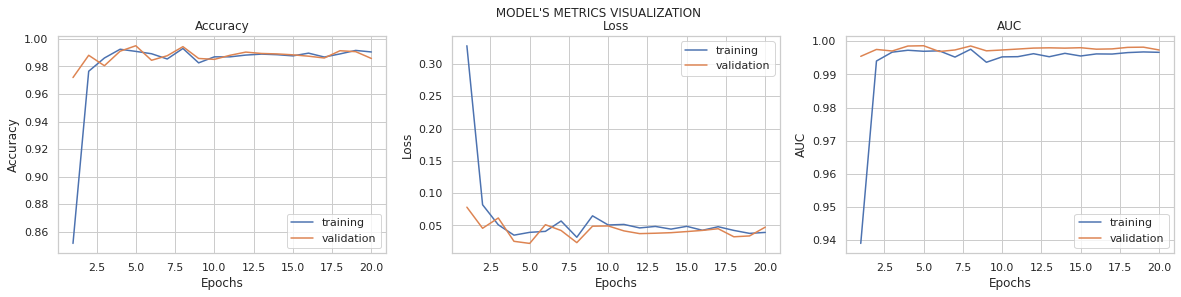

In [ ]:
def Train_Val_Plot1(acc,val_acc,loss,val_loss,auc,val_auc):
    
    fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot1(historylstm.history['accuracy'],historylstm.history['val_accuracy'],
               historylstm.history['loss'],historylstm.history['val_loss'],
               historylstm.history['auc'],historylstm.history['val_auc']
              )

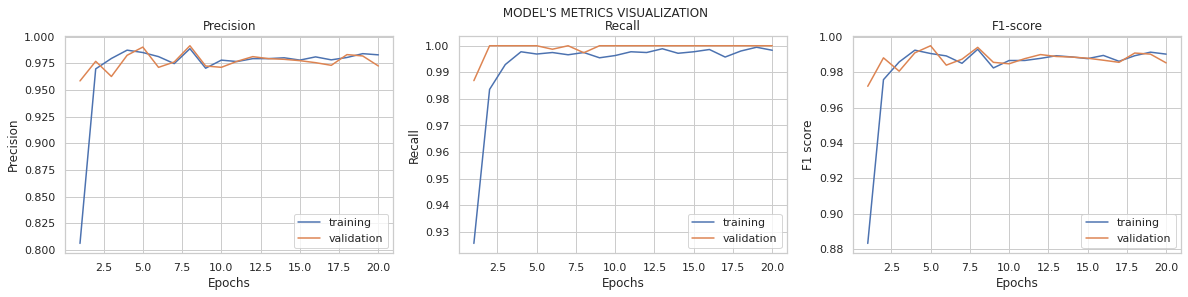

In [ ]:
def Train_Val_Plot2(precision,val_precision,recall,val_recall,f1,val_f1):
    
    fig, (ax4,ax5,ax6) = plt.subplots(1,3, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

   
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), recall)
    ax5.plot(range(1, len(val_f1) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    
    ax6.plot(range(1, len(f1) + 1), f1)
    ax6.plot(range(1, len(val_f1) + 1), val_f1)
    ax6.set_title('F1-score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('F1 score')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot2(historylstm.history['precision'],historylstm.history['val_precision'],
               historylstm.history['recall'],historylstm.history['val_recall'],
               historylstm.history['f1_score'],historylstm.history['val_f1_score']
              )

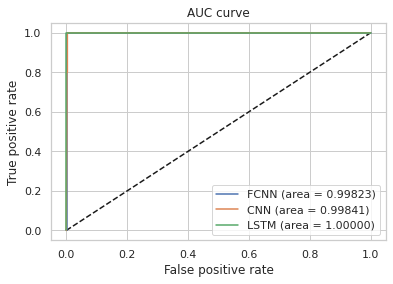

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='FCNN (area = {:.5f})'.format(auc_ann))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.5f})'.format(auc_cnn))
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.5f})'.format(auc_lstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC curve')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

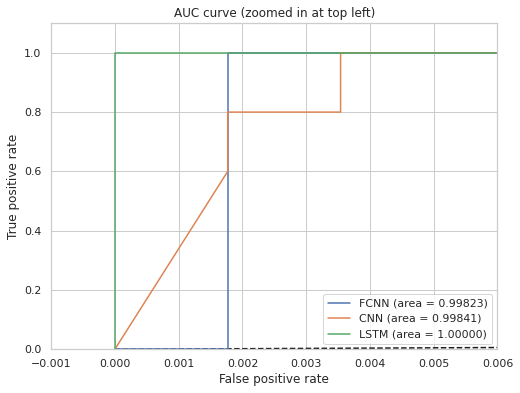

In [ ]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.figure(figsize=(8,6))
plt.xlim(-0.001, 0.006)
plt.ylim(0, 1.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='FCNN (area = {:.5f})'.format(auc_ann))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.5f})'.format(auc_cnn))
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.5f})'.format(auc_lstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.figure(figsize=(8,6))
plt.xlim(-0.001, 0.006)
plt.ylim(0, 1.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='FCNN (area = {:.5f})'.format(auc_ann))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.5f})'.format(auc_cnn))
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.5f})'.format(auc_lstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()